In [49]:
# basics
import numpy as np
import pandas as pd
import datetime
import re
import os

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);

np.seterr(divide = 'ignore');


In [2]:
# load data into datawrapper classes
measure_data = mc.COVID19_measures(download_data = True, measure_level = 2, only_first_dates = True, expand_measure_names = True)
jhu_data     = cdc.CoronaData(download_data = True)

# remove and rename countries to match the JFU database and the measures database
measure_data.RemoveCountry('Diamond Princess')
measure_data.RenameCountry('France (metropole)', 'France')
measure_data.RenameCountry('South Korea', 'Korea, South')
measure_data.RenameCountry('Czech Republic', 'Czechia')


results_Xval_rnd10_200411_4.csv
results_Xval_rnd10_200411_5.csv
results_Xval_200412_0.csv
results_Xval_200412_1.csv
results_Xval_200412_2.csv
results_Xval_200412_3.csv
results_Xval_200412_4.csv
results_Xval_200412_5.csv
results_Xval_200412_6.csv
results_Xval_200412_7.csv
results_Xval_200412_8.csv
results_Xval_200412_9.csv


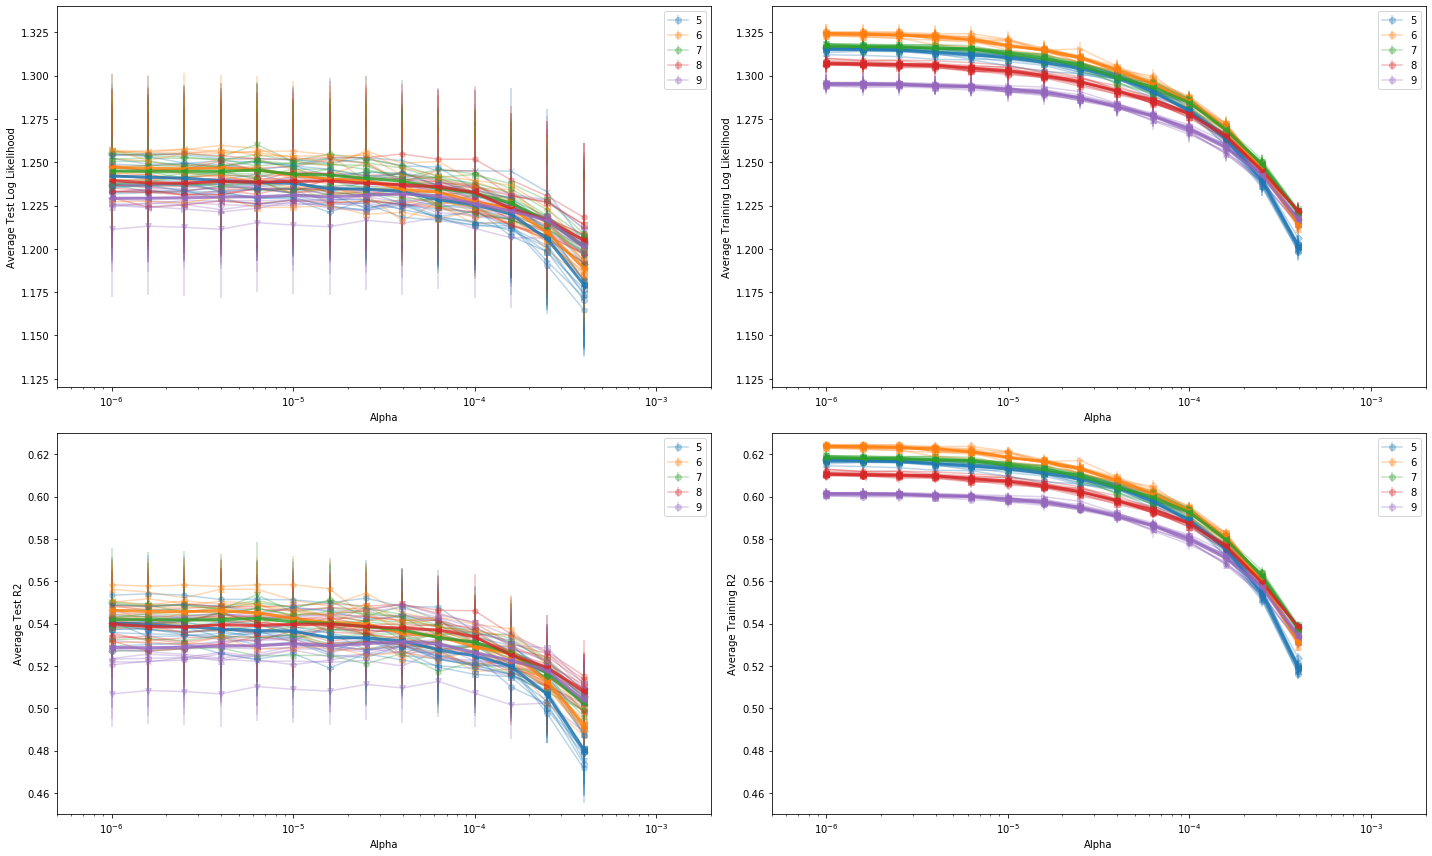

In [103]:
filelist_nomaxlen = [ 'results_Xval_rnd10_200411_4.csv',
                      'results_Xval_rnd10_200411_5.csv',
                      'results_Xval_200412_0.csv',
                      'results_Xval_200412_1.csv',
                      'results_Xval_200412_2.csv',
                      'results_Xval_200412_3.csv',
                      'results_Xval_200412_4.csv',
                      'results_Xval_200412_5.csv',
                      'results_Xval_200412_6.csv',
                      'results_Xval_200412_7.csv',
                      'results_Xval_200412_8.csv',
                      'results_Xval_200412_9.csv'
                    ]

filelist_maxlen = ['results_Xval_maxlen40_200412_{}.csv'.format(i) for i in range(10)]

markerlist = ['o','x','v','^','p','P','h','D','s','X','>','<']
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
alldata = []
resDF = None

fig,axis = plt.subplots(2,2,figsize = (20,12))
ax = axis.flatten()
for i,fn in enumerate(filelist_nomaxlen):
    print(fn)
    if os.path.exists(fn):
        alldata.append(pd.read_csv(fn))

        shiftdaylist = np.array(alldata[i]['shiftdays'].unique(),dtype=np.int)
        alphalist    = alldata[i]['alpha'].unique()

        for shiftdays in shiftdaylist:
            lltest_mean = []
            lltrain_mean = []
            lltest_std = []
            lltrain_std = []
            r2test_mean = []
            r2test_std  = []
            r2train_mean = []
            r2train_std = []
            for alpha in alphalist:
                boolidx = (alldata[i]['shiftdays']==shiftdays) & (alldata[i]['alpha'] == alpha)
                lltest_mean.append (np.mean((alldata[i][boolidx])['Loglike Test'])/153.)
                lltest_std.append  (np.std ((alldata[i][boolidx])['Loglike Test'])/153.)
                lltrain_mean.append(np.mean((alldata[i][boolidx])['Loglike Training'])/(9*153.))
                lltrain_std.append (np.std ((alldata[i][boolidx])['Loglike Training'])/(9*153.))

                r2test_mean.append (np.mean((alldata[i][boolidx])['R2 Test']))
                r2test_std.append  (np.std ((alldata[i][boolidx])['R2 Test']))
                r2train_mean.append(np.mean((alldata[i][boolidx])['R2 Training']))
                r2train_std.append (np.std ((alldata[i][boolidx])['R2 Training']))

            resdict = {'shiftdays':         shiftdays * np.ones(len(alphalist),dtype=int),
                       'alpha':             np.array(alphalist),
                       'filename':          fn,
                       'iteration':         i,
                       'loglike train':     np.array(lltrain_mean),
                       'loglike train std': np.array(lltrain_std)/np.sqrt(len(lltrain_std)),
                       'loglike test':      np.array(lltest_mean),
                       'loglike test std':  np.array(lltest_std)/np.sqrt(len(lltest_std)),
                       'R2 train':          np.array(r2train_mean),
                       'R2 train std':      np.array(r2train_std)/np.sqrt(len(r2train_std)),
                       'R2 test':           np.array(r2test_mean),
                       'R2 test std':       np.array(r2test_std)/np.sqrt(len(r2test_std)),

                      }

            if resDF is None:
                resDF = pd.DataFrame(resdict)
            else:
                resDF = resDF.append(pd.DataFrame(resdict), ignore_index = True)

            ax[0].errorbar(alphalist, resdict['loglike test'],  yerr = resdict['loglike test std'],  marker = markerlist[i], c = colornames[(shiftdays-5) % len(colornames)], alpha = .3)
            ax[1].errorbar(alphalist, resdict['loglike train'], yerr = resdict['loglike train std'], marker = markerlist[i], c = colornames[(shiftdays-5) % len(colornames)], alpha = .3)
            ax[2].errorbar(alphalist, resdict['R2 test'],       yerr = resdict['R2 test std'],       marker = markerlist[i], c = colornames[(shiftdays-5) % len(colornames)], alpha = .3)
            ax[3].errorbar(alphalist, resdict['R2 train'],      yerr = resdict['R2 train std'],      marker = markerlist[i], c = colornames[(shiftdays-5) % len(colornames)], alpha = .3)


        
# compute average and plot it

shiftdaylist = np.array(resDF['shiftdays'].unique(),dtype=np.int)
alphalist    = resDF['alpha'].unique()


for shiftdays in shiftdaylist:
    lltest_mean = []
    lltrain_mean = []
    lltest_std = []
    lltrain_std = []
    r2test_mean = []
    r2test_std  = []
    r2train_mean = []
    r2train_std = []
    for alpha in alphalist:
        boolidx = (resDF['shiftdays']==shiftdays) & (resDF['alpha'] == alpha)
        lltest_mean.append (np.mean((resDF[boolidx])['loglike test']))
        lltest_std.append  (np.std ((resDF[boolidx])['loglike test']))
        lltrain_mean.append(np.mean((resDF[boolidx])['loglike train']))
        lltrain_std.append (np.std ((resDF[boolidx])['loglike train']))

        r2test_mean.append (np.mean((resDF[boolidx])['R2 test']))
        r2test_std.append  (np.std ((resDF[boolidx])['R2 test']))
        r2train_mean.append(np.mean((resDF[boolidx])['R2 train']))
        r2train_std.append (np.std ((resDF[boolidx])['R2 train']))

    resdict = {'shiftdays':         shiftdays * np.ones(len(alphalist),dtype=int),
               'alpha':             np.array(alphalist),
               'filename':          fn,
               'iteration':         i,
               'loglike train':     np.array(lltrain_mean),
               'loglike train std': np.array(lltrain_std)/np.sqrt(len(lltrain_std)),
               'loglike test':      np.array(lltest_mean),
               'loglike test std':  np.array(lltest_std)/np.sqrt(len(lltest_std)),
               'R2 train':          np.array(r2train_mean),
               'R2 train std':      np.array(r2train_std)/np.sqrt(len(r2train_std)),
               'R2 test':           np.array(r2test_mean),
               'R2 test std':       np.array(r2test_std)/np.sqrt(len(r2test_std)),

              }


    ax[0].errorbar(alphalist, resdict['loglike test'],  yerr = resdict['loglike test std'],  marker = markerlist[i], c = colornames[(shiftdays-5) % len(colornames)], alpha = .8, lw =3)
    ax[1].errorbar(alphalist, resdict['loglike train'], yerr = resdict['loglike train std'], marker = markerlist[i], c = colornames[(shiftdays-5) % len(colornames)], alpha = .8, lw =3)
    ax[2].errorbar(alphalist, resdict['R2 test'],       yerr = resdict['R2 test std'],       marker = markerlist[i], c = colornames[(shiftdays-5) % len(colornames)], alpha = .8, lw =3)
    ax[3].errorbar(alphalist, resdict['R2 train'],      yerr = resdict['R2 train std'],      marker = markerlist[i], c = colornames[(shiftdays-5) % len(colornames)], alpha = .8, lw =3)



for i in range(4):
    ax[i].set_xlim([1e-6/2,2e-3])
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Alpha')
    ax[i].legend([5,6,7,8,9])
#ax[0].set_ylim([-10,1])
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_ylabel('Average Training Log Likelihood')
ax[2].set_ylabel('Average Test R2')
ax[3].set_ylabel('Average Training R2')
ax[0].set_ylim([1.12,1.34])
ax[1].set_ylim([1.12,1.34])
ax[2].set_ylim([.45,.63])
ax[3].set_ylim([.45,.63])

fig.tight_layout()
plt.savefig('loglikelihood_longrun.pdf')

resDF.to_csv('resDF_longrun_200412.csv')

#resDF.head()

In [64]:
regrDF6,ml = GetRegressionDF(countrylist = measure_data.countrylist, smooth = True, shiftdays = 6,maxlen=40)

/usr/lib64/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/lib64/python3.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


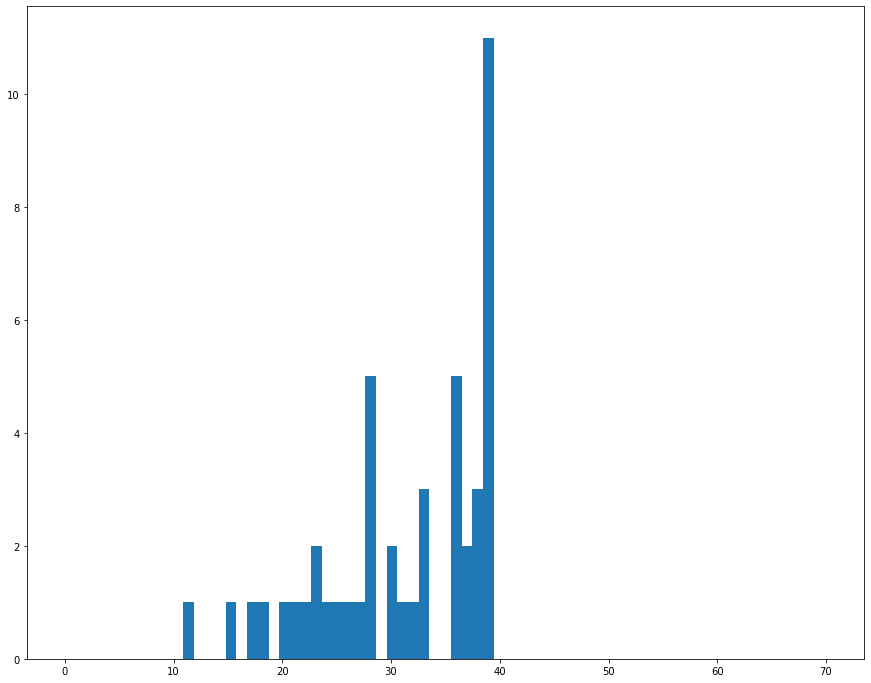

In [65]:
countrylist = list(regrDF6['Country'].unique())
trajlen = [len(regrDF6[regrDF6['Country'] == country]) for country in countrylist]

#for x in zip(countrylist,trajlen):
#    print(x)
plt.hist(trajlen, range=(0,70),bins=71)
plt.show()

In [75]:
sampleassignment = pd.read_csv('samplevec_Xval_200412.csv')

In [78]:
for i in range(10):
    print(i,np.sum(sampleassignment['rep{}'.format(i)]==i))

0 154
1 154
2 154
3 153
4 153
5 153
6 153
7 153
8 153
9 153


In [ ]:
# use parameters from country-wise cross validation
# shiftdays = 6, alpha = 2e-5
model_final6   = smf.ols(formula = formula, data = regrDF[6])
results_final6 = model_final6.fit_regularized(alpha = 2e-5, L1_wt = 1)

model_final7   = smf.ols(formula = formula, data = regrDF[7])
results_final7 = model_final7.fit_regularized(alpha = 2e-5, L1_wt = 1)

model_final8   = smf.ols(formula = formula, data = regrDF[8])
results_final8 = model_final8.fit_regularized(alpha = 2e-5, L1_wt = 1)



In [ ]:
colornames = ['gray','#f563e2','#609cff','#00bec4','#00b938','#b79f00','#f8766c']
#colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

countrylist = [paramname.split('.')[1].split(']')[0] for paramname in results_final7.params.index if paramname[:3] == 'C(C']

# collect measure names for labels
ml = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

intercept6 = results_final6.params['Intercept']
intercept7 = results_final7.params['Intercept']
intercept8 = results_final8.params['Intercept']


In [ ]:
def significanceColor(beta):
    if beta   >  0.00: return 'red'
    elif beta == 0.00: return 'lightgray'
    else:              return 'black'

    
l1list = list(measure_level_dict.keys())
l1list.sort()

fig,ax = plt.subplots(figsize = (10,23))

i = 0
groupcolor = 0

label_x = 1
label_x_header = .6
value_x  = 12
value_dx = 2
boxalpha = .15
ax.annotate('Country specific effects',[label_x_header, len(countrylist)], c = colornames[groupcolor], weight = 'bold' )

background = plt.Rectangle([label_x - .6, i - .65], value_x + 4.6, len(countrylist) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
ax.add_patch(background)


for country in countrylist[::-1]:
    ax.annotate(country, [label_x, i], c= colornames[groupcolor])
    beta_val6 = results_final6.params['C(Country)[T.{}]'.format(country)] / intercept6
    beta_val7 = results_final7.params['C(Country)[T.{}]'.format(country)] / intercept7
    beta_val8 = results_final8.params['C(Country)[T.{}]'.format(country)] / intercept8
    c6 = significanceColor(beta_val6)
    c7 = significanceColor(beta_val7)
    c8 = significanceColor(beta_val8)
    ax.annotate('{:6.0f}%'.format(beta_val6*100),[value_x + 0 * value_dx, i], c = c6, ha = 'right')
    ax.annotate('{:6.0f}%'.format(beta_val7*100),[value_x + 1 * value_dx, i], c = c7, ha = 'right')
    ax.annotate('{:6.0f}%'.format(beta_val8*100),[value_x + 2 * value_dx, i], c = c8, ha = 'right')
    i += 1

groupcolor += 1

i+=2 

for l1 in l1list[::-1]:
    ax.annotate(l1,[label_x_header, i + len(measure_level_dict[l1])], c = colornames[groupcolor], weight = 'bold')
    l2list = list(measure_level_dict[l1].keys())
    l2list.sort()
    
    background = plt.Rectangle([label_x - .6, i - .65], value_x + 4.6, len(measure_level_dict[l1]) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
    ax.add_patch(background)
    
    for l2 in l2list[::-1]:
        ax.annotate(l2,[label_x,i],c = colornames[groupcolor])
        beta_val6 = results_final6.params[measure_level_dict[l1][l2]]/intercept6
        beta_val7 = results_final7.params[measure_level_dict[l1][l2]]/intercept7
        beta_val8 = results_final8.params[measure_level_dict[l1][l2]]/intercept8
        c6 = significanceColor(beta_val6)
        c7 = significanceColor(beta_val7)
        c8 = significanceColor(beta_val8)
        ax.annotate('{:6.0f}%'.format(beta_val6*100),[value_x + 0 * value_dx,i],c=c6,ha='right')
        ax.annotate('{:6.0f}%'.format(beta_val7*100),[value_x + 1 * value_dx,i],c=c7,ha='right')
        ax.annotate('{:6.0f}%'.format(beta_val8*100),[value_x + 2 * value_dx,i],c=c8,ha='right')
        i+=1
    i+=2
    groupcolor += 1
        #print('  {:60s} {:6.3f}'.format(l2,results_final.params[measure_level_dict[l1][l2]]/intercept))

ax.annotate('s = 6', [value_x + 0*value_dx,i],ha='right')        
ax.annotate('s = 7', [value_x + 1*value_dx,i],ha='right')        
ax.annotate('s = 8', [value_x + 2*value_dx,i],ha='right')

ax.set_xlim([0,20])
ax.set_ylim([-1,i+1])
ax.axis('off')
plt.savefig('effects_measures.pdf')


In [ ]:
#specialcountries = ['Austria','Germany','Thailand', 'Italy', 'Spain', 'Sweden',
#                    'Japan', 'Hungary', 'France', 'Mexico', 'Netherlands', 'Korea, South']
specialcountries = regrDF[6]['Country'].unique()
cm = GetCountryMasks(regrDF[6])

plotxcount = int(len(specialcountries)/2) + len(specialcountries)%2

fig,ax = plt.subplots(plotxcount,2,figsize = (15,3*plotxcount))
ax = ax.flatten()

for i,country in enumerate(specialcountries):
    dlc = np.array(regrDF[6][cm[country]]['Observable'])
    pred = results_final6.predict()[cm[country]]
    ax[i].plot(dlc, lw = 3, c = 'TAB:BLUE', label = r'$\Delta \log C$')
    ax[i].plot(pred, lw = 3, c = 'TAB:ORANGE', linestyle = '--', label = 'Fitted Model Prediction')
    ax[i].set_ylim([0,.5])
    ax[i].set_xlim([0,50])
    ax[i].annotate(country, [20,.45],ha = 'center',fontsize = 15)
    ax[i].legend()
fig.tight_layout()
plt.savefig('regression_trajectories.pdf')


In [ ]:
import pickle

pickle.dump(regrDF, open('pickle/regrDF.pickle','wb'))
pickle.dump(regrDF_test, open('pickle/regrDF_test.pickle','wb'))
pickle.dump(regrDF_train, open('pickle/regrDF_train.pickle','wb'))
pickle.dump(model_excludeC, open('pickle/model_excludeC.pickle','wb'))
pickle.dump(model_singleC, open('pickle/model_singleC.pickle','wb'))


In [ ]:
tmp = 

results_doublealpha_200412.csv
    alphacountry     alpha                        filename  iteration  \
0       0.000001  0.000001  results_doublealpha_200412.csv          0   
1       0.000001  0.000010  results_doublealpha_200412.csv          0   
2       0.000001  0.000100  results_doublealpha_200412.csv          0   
3       0.000001  0.001000  results_doublealpha_200412.csv          0   
4       0.000010  0.000001  results_doublealpha_200412.csv          0   
5       0.000010  0.000010  results_doublealpha_200412.csv          0   
6       0.000010  0.000100  results_doublealpha_200412.csv          0   
7       0.000010  0.001000  results_doublealpha_200412.csv          0   
8       0.000100  0.000001  results_doublealpha_200412.csv          0   
9       0.000100  0.000010  results_doublealpha_200412.csv          0   
10      0.000100  0.000100  results_doublealpha_200412.csv          0   
11      0.000100  0.001000  results_doublealpha_200412.csv          0   
12      0.001000  0.

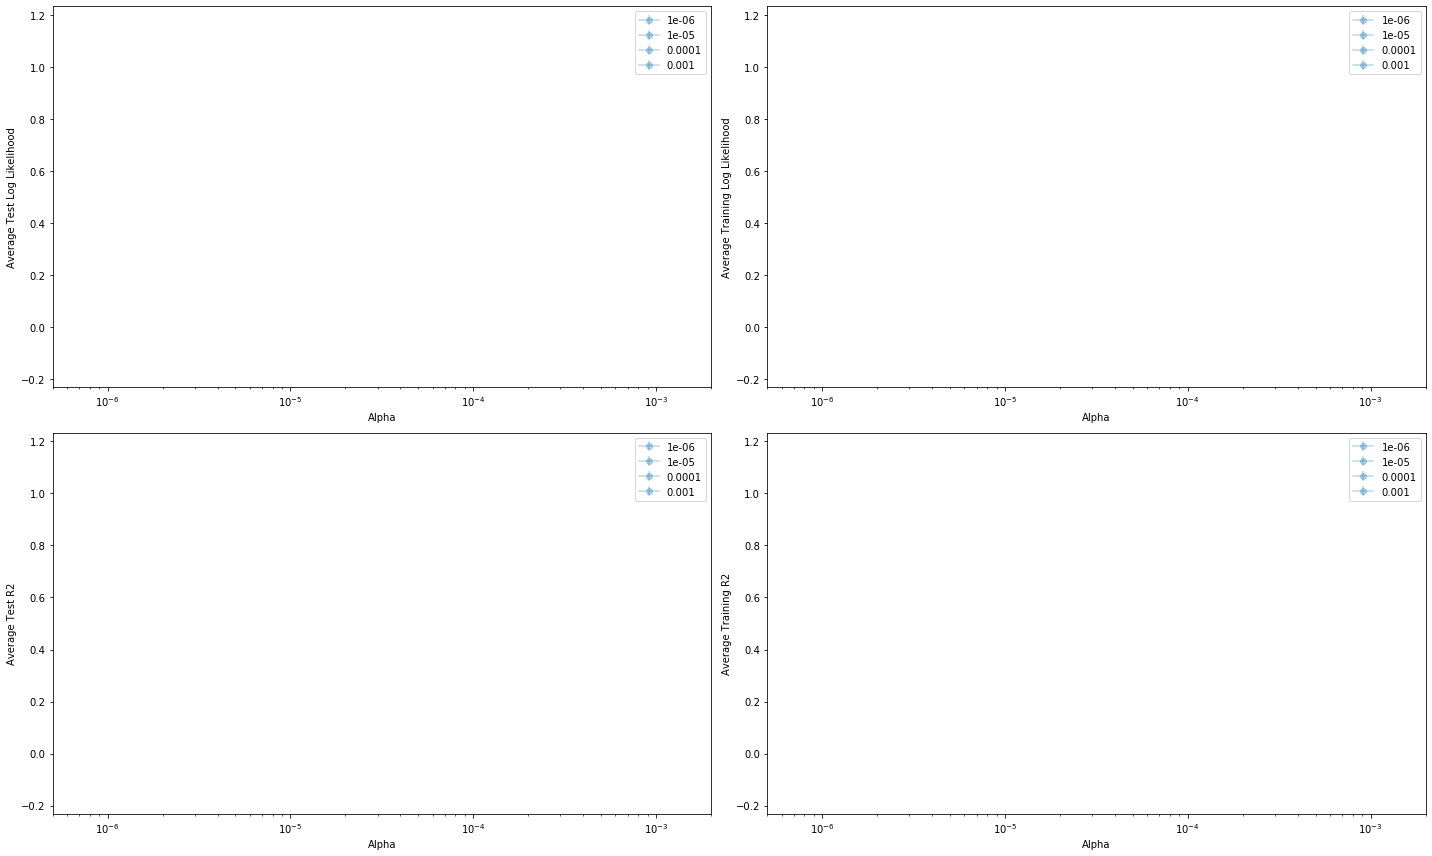

In [93]:
filelist_nomaxlen = [ 'results_Xval_rnd10_200411_4.csv',
                      'results_Xval_rnd10_200411_5.csv',
                      'results_Xval_200412_0.csv',
                      'results_Xval_200412_1.csv',
                      'results_Xval_200412_2.csv',
                      'results_Xval_200412_3.csv',
                      'results_Xval_200412_4.csv',
                      'results_Xval_200412_5.csv',
                      'results_Xval_200412_6.csv',
                      'results_Xval_200412_7.csv',
                      'results_Xval_200412_8.csv',
                      'results_Xval_200412_9.csv'
                    ]

filelist_maxlen = ['results_Xval_maxlen40_200412_{}.csv'.format(i) for i in range(10)]

filelist_da = ['results_doublealpha_200412.csv']

markerlist = ['o','x','v','^','p','P','h','D','s','X','>','<']
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
alldata = []
resDF = None

fig,axis = plt.subplots(2,2,figsize = (20,12))
ax = axis.flatten()
for i,fn in enumerate(filelist_da):
    print(fn)
    if os.path.exists(fn):
        alldata.append(pd.read_csv(fn))

        alphaclist   = alldata[i]['alphacountry'].unique()
        alphalist    = alldata[i]['alpha'].unique()

        for alphac in alphaclist:
            lltest_mean = []
            lltrain_mean = []
            lltest_std = []
            lltrain_std = []
            r2test_mean = []
            r2test_std  = []
            r2train_mean = []
            r2train_std = []
            for alpha in alphalist:
                boolidx = (alldata[i]['alphacountry']==shiftdays) & (alldata[i]['alpha'] == alpha)
                lltest_mean.append (np.mean((alldata[i][boolidx])['Loglike Test'])/153.)
                lltest_std.append  (np.std ((alldata[i][boolidx])['Loglike Test'])/153.)
                lltrain_mean.append(np.mean((alldata[i][boolidx])['Loglike Training'])/(9*153.))
                lltrain_std.append (np.std ((alldata[i][boolidx])['Loglike Training'])/(9*153.))

                r2test_mean.append (np.mean((alldata[i][boolidx])['R2 Test']))
                r2test_std.append  (np.std ((alldata[i][boolidx])['R2 Test']))
                r2train_mean.append(np.mean((alldata[i][boolidx])['R2 Training']))
                r2train_std.append (np.std ((alldata[i][boolidx])['R2 Training']))

            resdict = {'alphacountry':         alphac * np.ones(len(alphalist),dtype=int),
                       'alpha':             np.array(alphalist),
                       'filename':          fn,
                       'iteration':         i,
                       'loglike train':     np.array(lltrain_mean),
                       'loglike train std': np.array(lltrain_std)/np.sqrt(len(lltrain_std)),
                       'loglike test':      np.array(lltest_mean),
                       'loglike test std':  np.array(lltest_std)/np.sqrt(len(lltest_std)),
                       'R2 train':          np.array(r2train_mean),
                       'R2 train std':      np.array(r2train_std)/np.sqrt(len(r2train_std)),
                       'R2 test':           np.array(r2test_mean),
                       'R2 test std':       np.array(r2test_std)/np.sqrt(len(r2test_std)),

                      }

            if resDF is None:
                resDF = pd.DataFrame(resdict)
            else:
                resDF = resDF.append(pd.DataFrame(resdict), ignore_index = True)

            ax[0].errorbar(alphalist, resdict['loglike test'],  yerr = resdict['loglike test std'],  marker = markerlist[i], c = colornames[0], alpha = .3)
            ax[1].errorbar(alphalist, resdict['loglike train'], yerr = resdict['loglike train std'], marker = markerlist[i], c = colornames[0], alpha = .3)
            ax[2].errorbar(alphalist, resdict['R2 test'],       yerr = resdict['R2 test std'],       marker = markerlist[i], c = colornames[0], alpha = .3)
            ax[3].errorbar(alphalist, resdict['R2 train'],      yerr = resdict['R2 train std'],      marker = markerlist[i], c = colornames[0], alpha = .3)

    print(resDF)
        
# compute average and plot it



for i in range(4):
    ax[i].set_xlim([1e-6/2,2e-3])
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Alpha')
    ax[i].legend(alphaclist)
#ax[0].set_ylim([-10,1])
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_ylabel('Average Training Log Likelihood')
ax[2].set_ylabel('Average Test R2')
ax[3].set_ylabel('Average Training R2')
#ax[0].set_ylim([1,1.4])
#ax[1].set_ylim([1,1.4])
#ax[2].set_ylim([.45,.65])
#ax[3].set_ylim([.45,.65])

fig.tight_layout()
plt.savefig('loglikelihood_longrun.pdf')

resDF.to_csv('resDF_longrun_200412.csv')

#resDF.head()

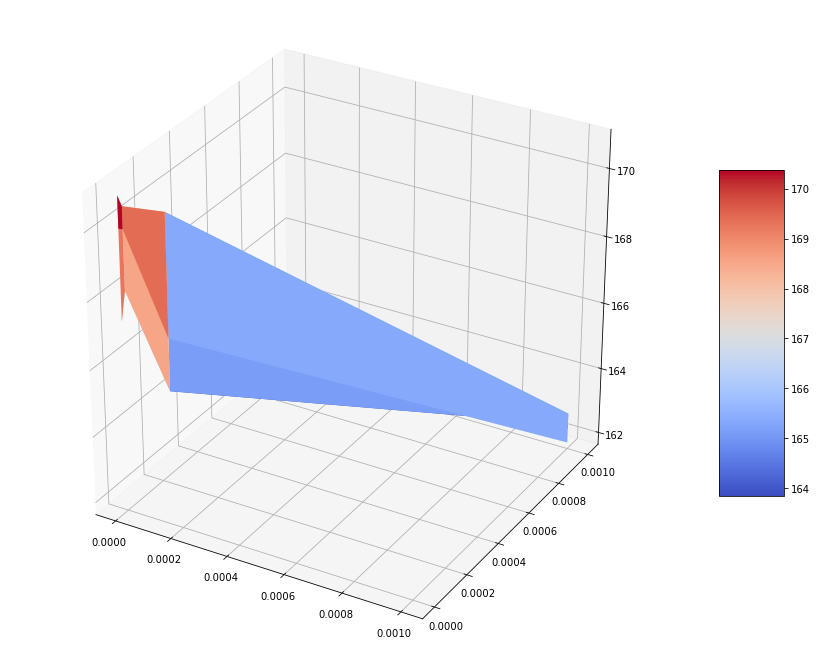

In [97]:
allres_da = pd.read_csv('results_doublealpha_200412.csv')

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.gca(projection = '3d')
x = np.array(allres_da['alpha'].unique())
y = np.array(allres_da['alphacountry'].unique())
z = np.array(allres_da['Loglike Test']).reshape(len(x),len(y))
surf = ax.plot_surface(x,y,z, cmap = matplotlib.cm.coolwarm)
fig.colorbar(surf,shrink=.5,aspect=5)
plt.show()

In [98]:
allres_da.head()

,Unnamed: 0,shiftdays,alpha,alphacountry,iteration,Loglike Training,Loglike Test,R2 Training,R2 Test,RSS Training,...,RepurposeHospitals,TrainTransportRestrictions,UseOfPublicTransport,EnvironmentalCleaningAndDisinfection,Surveillance,WorkSafetyProtocols,SpecialMeasuresForCertainEstablishments,IncreaseHealthcareWorkforce,FixingPriceForSpecificProtectiveProducts,AirportsClosingForAllInternationalFlights
0,0,7.0,0.000001,0.000001,0.0,1675.844237,167.464301,0.619527,0.482497,5.572967,...,0.004353,-0.059206,0.000000,0.015783,-0.061362,0.005019,0.058054,-0.005758,0.051690,0.013641
1,1,7.0,0.000001,0.000010,0.0,1676.461996,168.288382,0.619892,0.488386,5.567620,...,0.004118,-0.058268,-0.021189,0.013543,-0.063614,0.004148,0.057814,-0.004322,0.053184,0.012950
2,2,7.0,0.000001,0.000100,0.0,1642.139785,165.679502,0.599068,0.469508,5.872641,...,0.030816,-0.046844,-0.022810,-0.003296,-0.067153,0.000184,0.040272,-0.021270,0.032667,0.024532
3,3,7.0,0.000001,0.001000,0.0,1491.117423,162.256285,0.493015,0.443677,7.426045,...,0.038284,0.007385,-0.051357,-0.018810,-0.062789,-0.012074,-0.024272,-0.027473,-0.015697,-0.004530
4,4,7.0,0.000010,0.000001,0.0,1674.881831,167.314244,0.618957,0.481417,5.581308,...,0.006549,-0.057654,0.000000,0.015721,-0.060492,0.000546,0.055948,-0.008339,0.046450,0.014876
